# 1. 필요한 모듈 import하기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import scipy as sp

# 2. 데이터 불러오기 및 데이터 전처리

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 1) date 길이 줄여주기

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2) 데이터 요약분석

In [5]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

### 결측치 확인

<AxesSubplot:>

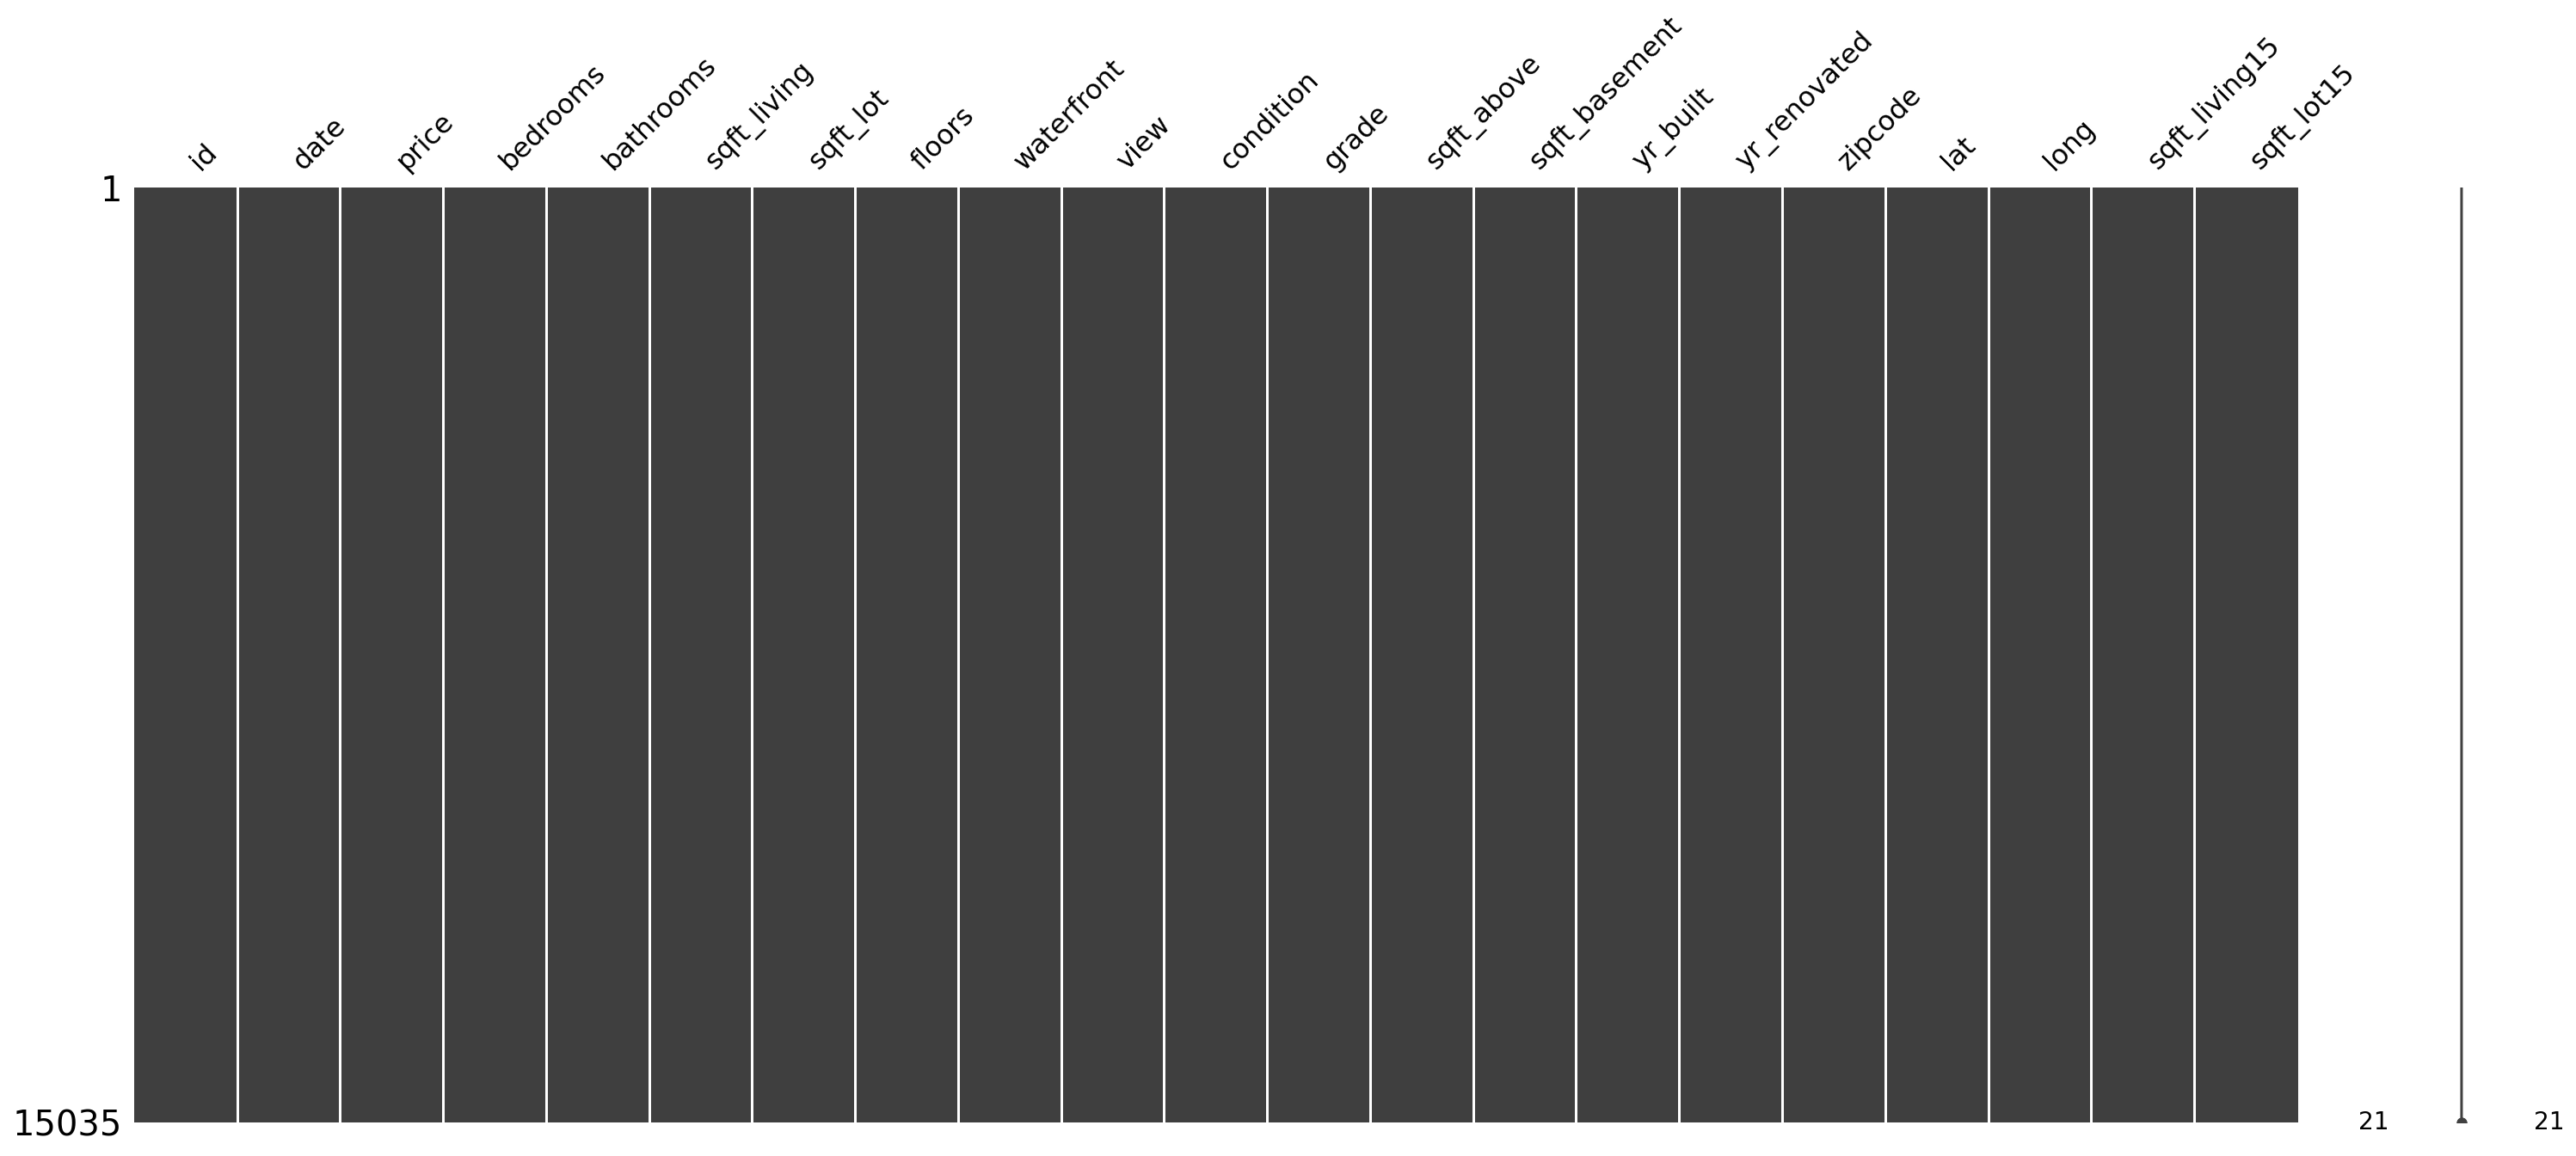

In [6]:
msno.matrix(train)

### price에 대한 예측을 해야되므로 따로 빼준다

### 데이터가 몰려있는지 확인

- 양의 왜도라 왼쪽에 자료가 몰림, 좌측으로 치우친 그래프

- 분포가 중심근처에서 퍼져있는 정도, '3' 이면 표준정규분포, 3보다 값이 큼, 표준정규분포보다 정점이 높고, 뾰족한 모양

왜도: 4.290252
첨도: 40.154919


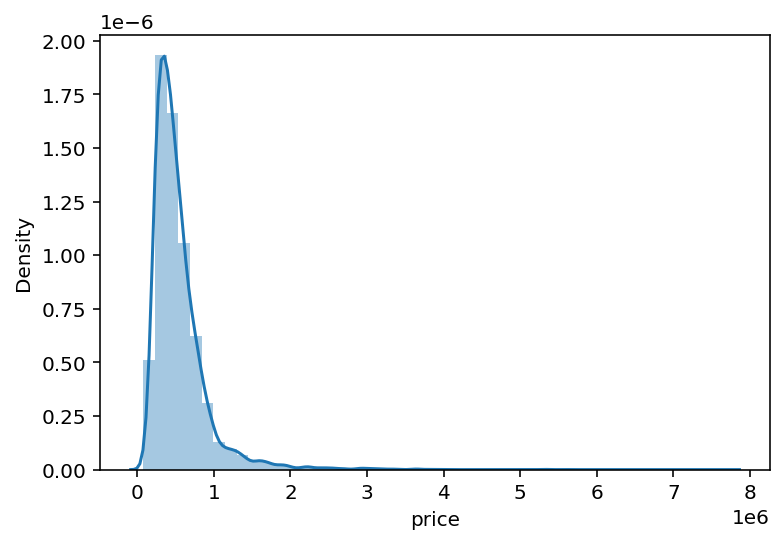

In [7]:
sns.distplot(train['price'])
print("왜도: %f" % train['price'].skew())
print("첨도: %f" % train['price'].kurt())
plt.show()

### 왼쪽으로 치우친 데이터를 log를 사용해 정규화 시켜준다.

왜도: 0.433099
첨도: 0.731605


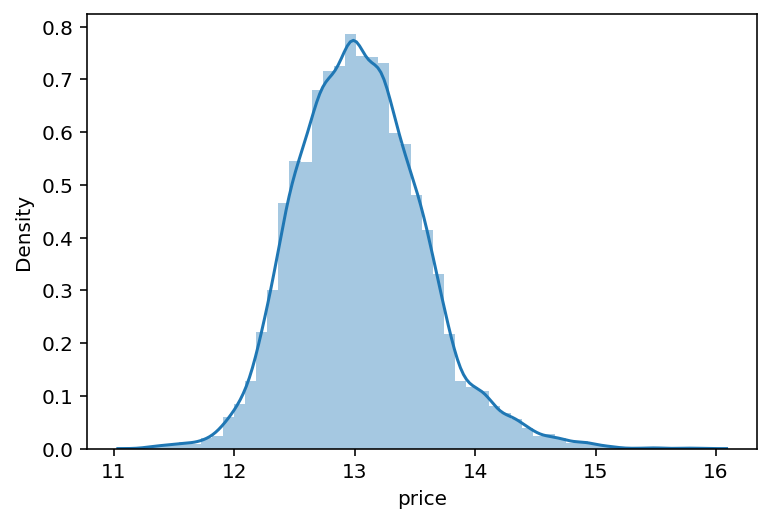

In [8]:
train['price'] = np.log1p(train['price'])
print("왜도: %f" % train['price'].skew())
print("첨도: %f" % train['price'].kurt())
sns.distplot(train['price'])
plt.show()

### 다른 값과 price 간의 결정계수 확인

피어슨 상관계수, 두 변수간 선형적인 관계가 있는지 판단하는데 사용한다. 두 변수간의 관계가 있는지 보는 지표가 아니다. 피어슨 상관계수가 0에 가까운 수치를 보이더라도 선형적인 관계가 낮다는 것일 뿐 비선형적인 관계로 유의미한 관련이 있을 수도 있다.

In [9]:
cor = train.corr()
cor['price'].sort_values(ascending=False)

price            1.000000
grade            0.707412
sqft_living      0.697907
sqft_living15    0.621800
sqft_above       0.607197
bathrooms        0.552000
lat              0.444417
bedrooms         0.359946
view             0.347506
floors           0.317810
sqft_basement    0.314378
waterfront       0.172580
yr_renovated     0.127533
sqft_lot         0.108946
sqft_lot15       0.096976
yr_built         0.076293
long             0.054362
condition        0.042947
id               0.035940
date             0.009466
zipcode         -0.039195
Name: price, dtype: float64

피어슨 상관계수는 원 데이터 수치값을 그대로 활용하는 반면 스피어슨 상관계수는 데이터의 순서통계량 값을 활용하여 순서값의 피어슨 상관계수다

In [10]:
cor = train.corr(method='spearman')
cor['price'].sort_values(ascending=False)

price            1.000000
grade            0.662125
sqft_living      0.646482
sqft_living15    0.573777
sqft_above       0.547868
bathrooms        0.498989
lat              0.450692
bedrooms         0.350185
floors           0.328674
view             0.291720
sqft_basement    0.245304
waterfront       0.113179
yr_renovated     0.112381
yr_built         0.097844
sqft_lot         0.080554
long             0.071757
sqft_lot15       0.065771
id               0.036892
condition        0.021520
date            -0.001679
zipcode         -0.009266
Name: price, dtype: float64

In [11]:
cor_abs = abs(cor) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index
print(cor_cols.values)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


In [12]:
cor[cor_cols].loc['price']

price            1.000000
grade            0.662125
sqft_living      0.646482
sqft_living15    0.573777
sqft_above       0.547868
bathrooms        0.498989
lat              0.450692
bedrooms         0.350185
floors           0.328674
view             0.291720
Name: price, dtype: float64

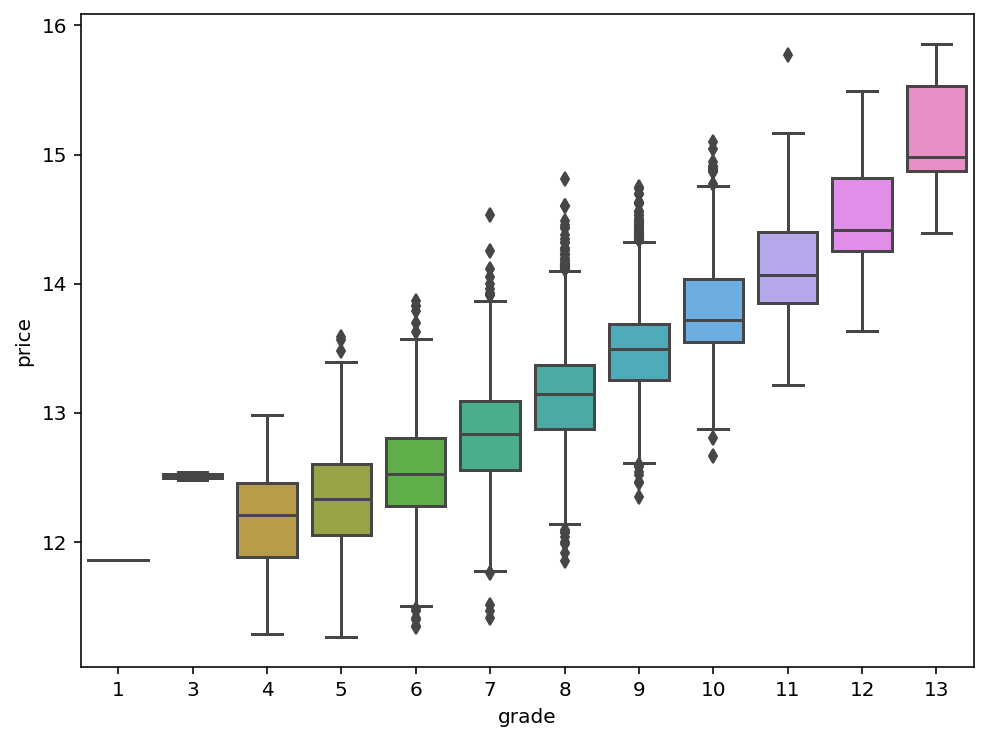

In [13]:
data = pd.concat([train['price'],train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig=sns.boxplot(x='grade',y='price',data=data)

### 이상치 확인

In [14]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [15]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [16]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


집 등급이 높을수록 가격이 높은 것을 확인했다. but, 3등급이 4등급보다 높은 가격이 책정되는 것을 살펴봐야한다. <br>
7, 8, 11 등급에 이상치가 나오는 것을 확인했다. 8번 11번의 평균값이 높은 이유가 최대값과 최저값의 차이가 크기 때문인 것을 발견했다.

항목이 많아서 산점도 그래프를 사용했고 추세선을 사용하기위해 regplot 그래프 적용

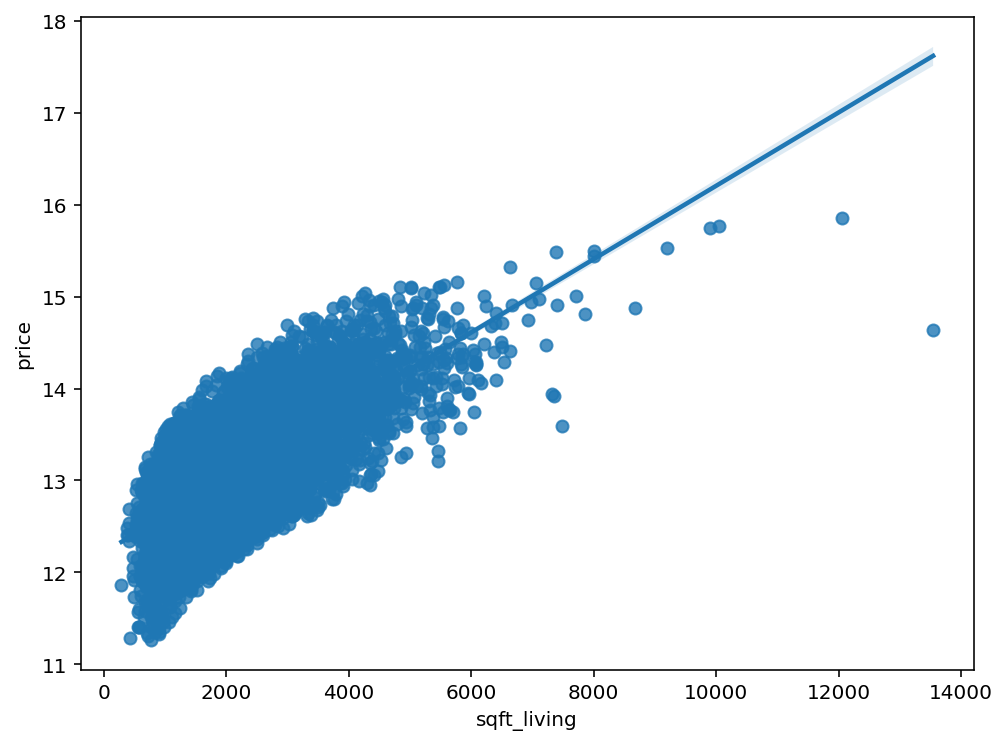

In [17]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

### 이상치 확인

In [18]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


'sqft_living15' 데이터는 가격의 분산이 큰 것을 확인했다.

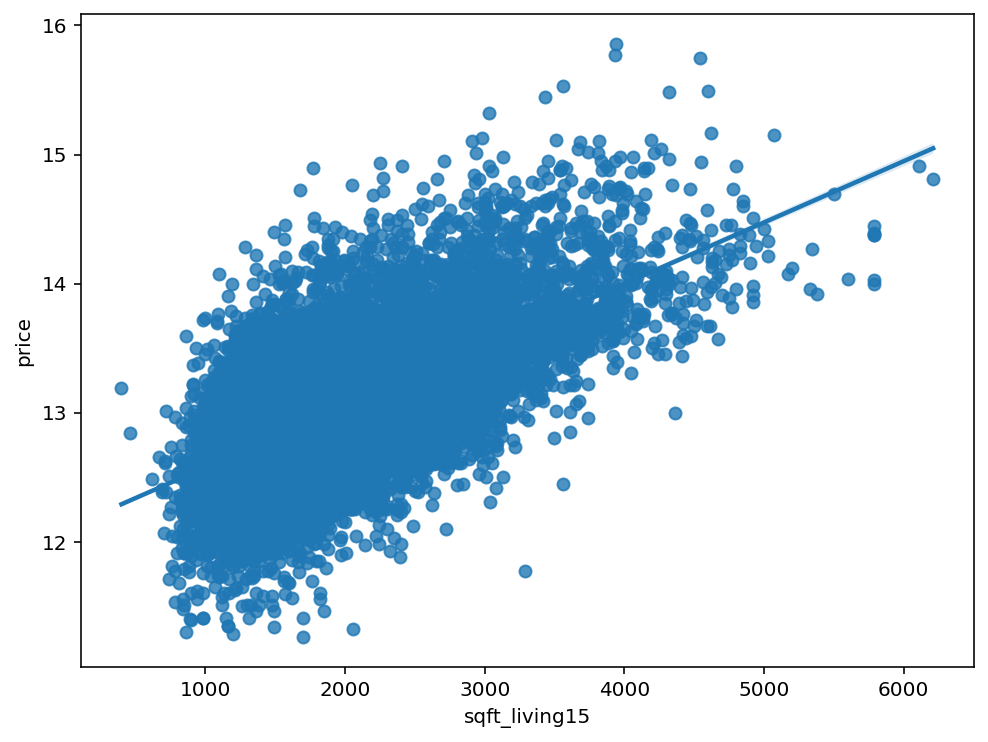

In [19]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

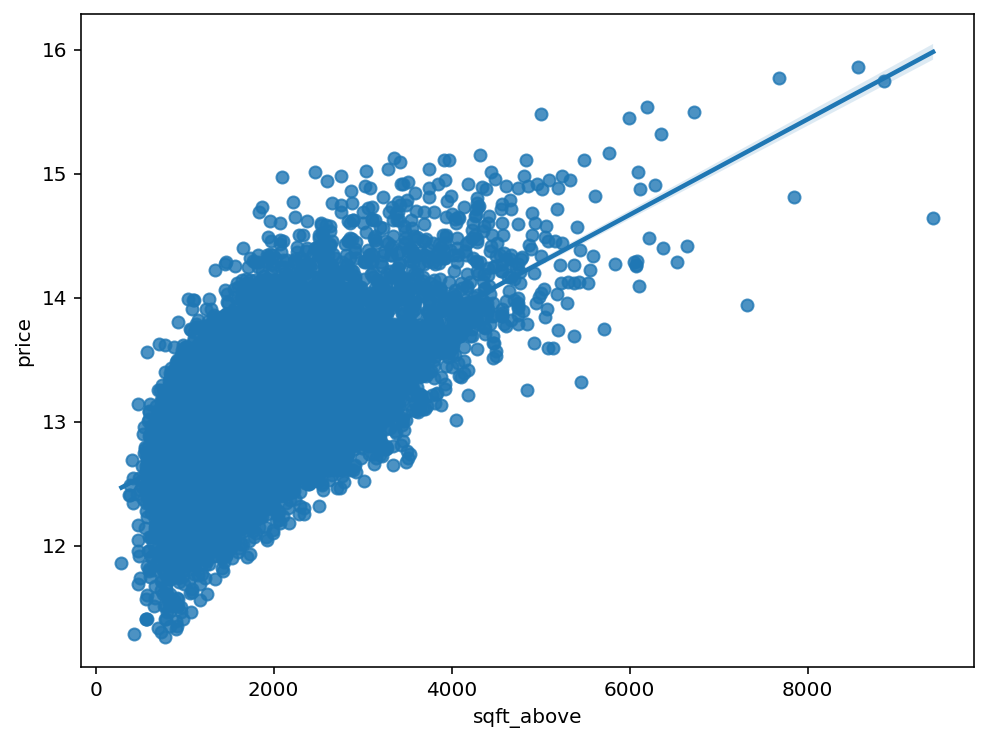

In [20]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

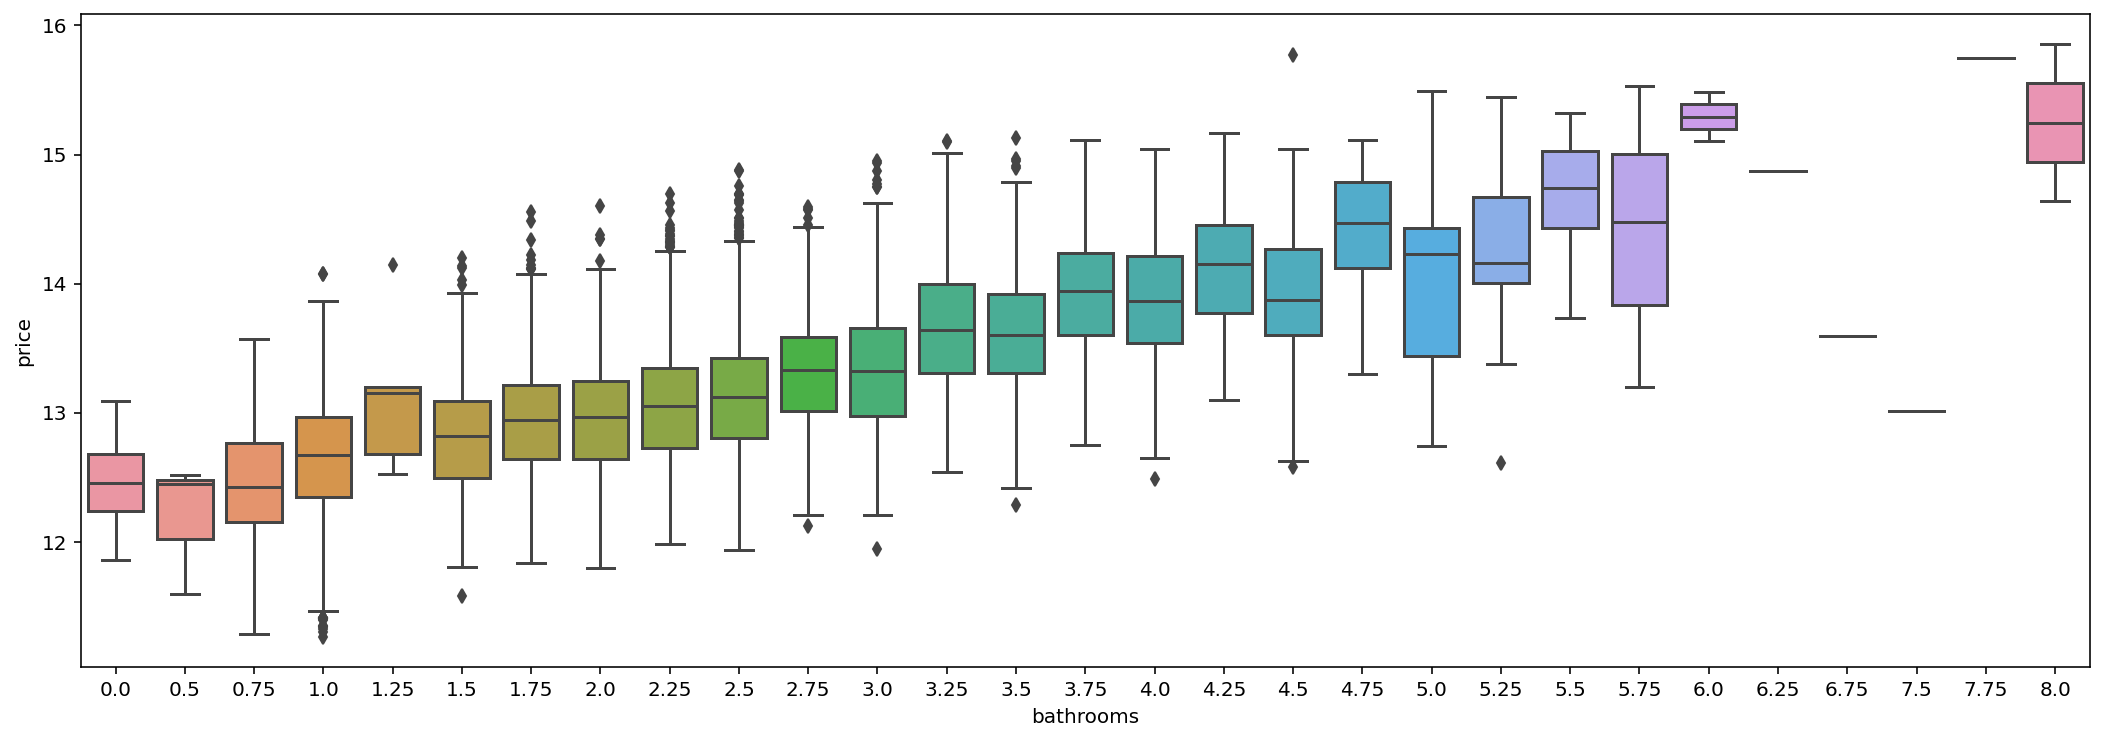

In [21]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

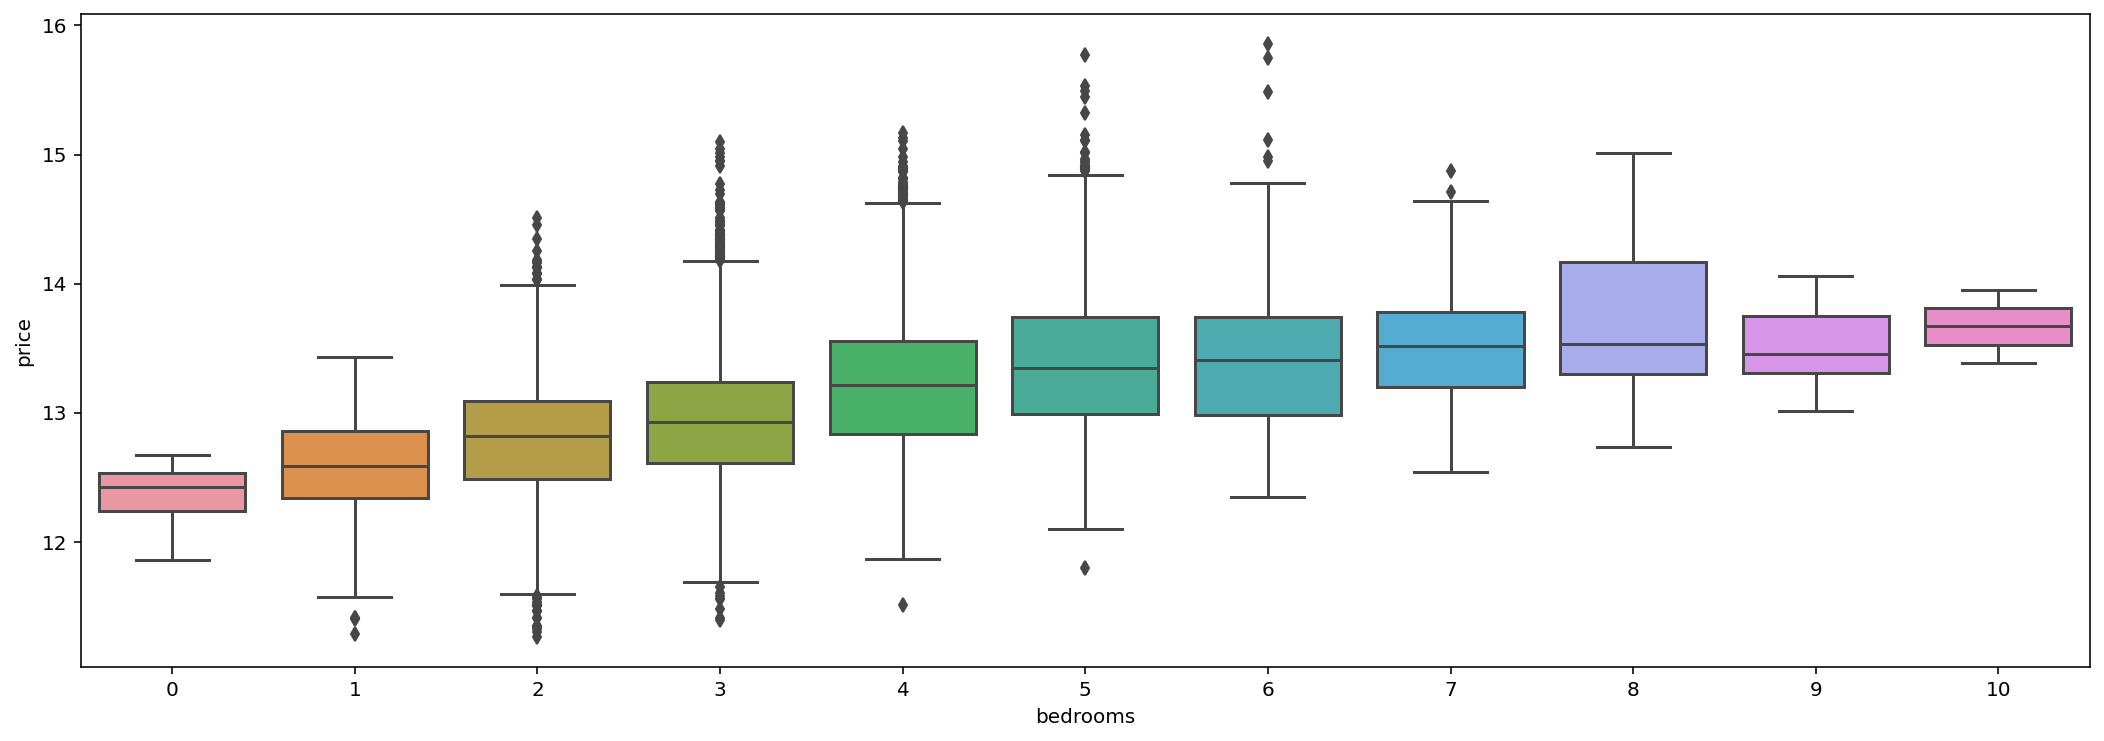

In [22]:
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [23]:
train_unique=[]
columns=['bedrooms','bathrooms','floors','waterfront','view','condition','grade']
for i in columns:
    train_unique.append(len(train[i].unique()))
unique = pd.DataFrame(train_unique, index=columns)
unique

,0
bedrooms,11
bathrooms,29
floors,6
waterfront,2
view,5
condition,5
grade,12


'waterfront'는 있다 없다 0 ,1 로 구성된 것을 확인했다

### 위에 그래프를 보고 분석해 낸 이상치를 제거한다

In [24]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]
train = train.loc[train['id']!=8912]

<https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline>

In [25]:
y = train['price']
del train['price']
print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 2) 타깃 데이터에 해당하는 price 제거 후 y변수에 넣기

In [26]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15030, dtype: float64

#### 불필요한 요소인 id 제거

In [27]:
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### 3) test 데이터 전처리

In [28]:
test.head() 

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [29]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [30]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## 3. 데이터 분석

### 1) 훈련 데이터와 검증 데이터를 나누기 위해 모듈 추가

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### 2) RMSE 평균제곱근 편차를 구하기 위해 로그로 변환된 값을 원래대로 돌린다

[참조](https://steadiness-193.tistory.com/224)

In [32]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 3) 앙상블을 할 모델 추가

In [33]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

**XGBoost는 Extreme Gradient Boosting의 약자이다.**
Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적인데
이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.

**XGBoost의 장점**

- GBM 대비 빠른 수행시간
    - 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
    - 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
    - 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
    - 다양한 옵션을 제공하며 Customizing이 용이하다.

[참고 XGBoost](https://wooono.tistory.com/97)

**Light GBM**은 트리 기반의 학습 알고리즘인 gradient boosting 방식의 프레임 워크이다

수평으로 확장하는 다른 모델들과는 다르게 Light GBM은 나무를 수직으로 확장한다. 따라서 기존의 알고리즘은 수평으로 확장하여 포화 트리를 만드는 방향으로 학습하는 반면 leaf-wise tree growth인 LGBM은 최대 delta loss가 증가하도록 잎의 개수를 정한다. leaf-wise 알고리즘은 다른 level-wise 알고리즘보다 낮은 loss를 달성하는 경향이 있다. 데이터의 크기가 작은 경우 leaf-wise는 과적합되기 쉬우므로 max_depth를 줄여줘야 한다

Light GBM은 Light 의 접두사와 같이 속도가 빠른 것이 장점이다. 메모리를 적게 차지하고 속도가 빠르다는 장점 외에도, LGBM은 결과의 정확도가 높다는 장점이 있다. 또한 GPU를 사용할 수 있기 때문에 널리 사용되고 있다. 하지만 과적합에 민감하여 데이터 크기가 작을 경우 기존의 머신러닝 알고리즘이 더 좋을 수 있다. 데이터 행의 개수가 10,000개 이상일 때 추천

[참고 Light GBM](https://greatjoy.tistory.com/72)

In [34]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### 4) 데이터 학습 및 예측

In [35]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
score_df

,RMSE
GradientBoostingRegressor,133347.775454
RandomForestRegressor,127611.388134
XGBRegressor,110960.588243
LGBMRegressor,109543.524886


## 함수로 모델 RMSE구하기

In [36]:
def get_scores(models, train, y):    #RMSE 결괏값을 나타내주는 함수
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

## 4. 함수를 사용해서 결과값을 보고 더 좋은 방안 생각하기

In [37]:
from sklearn.model_selection import GridSearchCV        #그리드 서치를 하기 위해서 import

In [38]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [39]:
param_grid = {
    'n_estimators': [1000,1200],
    'max_depth': [3,5,7,9,13],
    #'learning_rate':[0.01,0.1],
    'num_leaves': [40],
    'min_child_samples': [26],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,max_depth,min_child_samples,n_estimators,num_leaves,score,RMSLE
1,3,26,1200,40,-0.026154,0.161723
0,3,26,1000,40,-0.026212,0.161902
2,5,26,1000,40,-0.026514,0.162831
3,5,26,1200,40,-0.026724,0.163474
8,13,26,1000,40,-0.026982,0.164262
4,7,26,1000,40,-0.026991,0.164289
9,13,26,1200,40,-0.027141,0.164746
5,7,26,1200,40,-0.027178,0.164856
6,9,26,1000,40,-0.027228,0.165009
7,9,26,1200,40,-0.027445,0.165667


In [40]:
model = LGBMRegressor(max_depth=3, n_estimators=1200,num_leaves=40,min_child_samples=26, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)        #로그함수를 다시 되돌린다
prediction

array([ 530859.39154205,  474794.91026969, 1423179.45843845, ...,
        485180.84805581,  309896.63435292,  459181.26204847])

In [41]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [42]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.308594e+05
1,15036,4.747949e+05
2,15037,1.423179e+06
3,15038,3.146828e+05
4,15039,3.284266e+05


In [43]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [44]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


# 5. 회고

<https://velog.io/@sset2323/04-07.-LightGBM>

<https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12>

초기에 프로그램을 썼을 때 4개의 모델값이 차이가 많이나서 각각의 모델의 파라미터를 조정하기보다는 데이터의 이상치를 제거해서 모델간의 수치 차이를 낮추려고 했고, 캐글에 올라온 다른 내용을 참고해서 모델간의 차이를 줄이는데 성공했다. "learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋지만 n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있다." 라는 글을 찾아보고 n_estimators를 늘리고 learning_rate를 0.01, 0.1, 0.001 값을 주고 그리드 서치를 진행했고 결과적으로 default 값인 0.1로 한 수치가 제일 잘 나온것을 확인 했다. "num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안이다." 를 참고하여 num_leaves값을 늘려 모델의 복잡도를 늘리고 min_child_samples값을 30을 주고 1씩 낮추면서 복잡도를 조정했다. min_child_samples값을 늘릴 수록 결과가 좋지않아서 낮추는 방향으로 갔다.

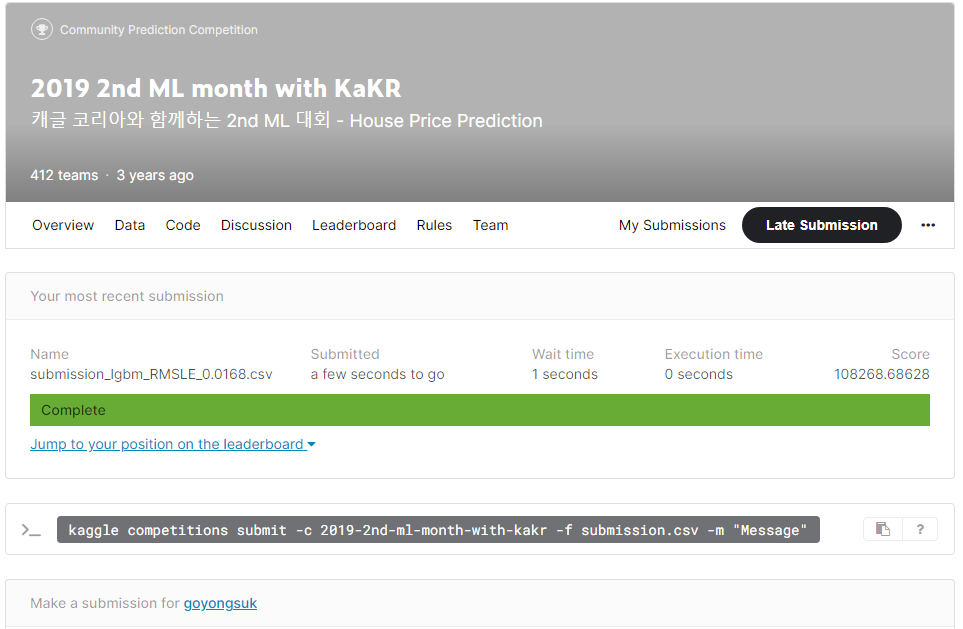

In [45]:
from PIL import Image
img_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/kaggle.PNG'
im=Image.open(img_path)
im